In [101]:
# First use ffmpeg to generate some videos:

import subprocess
import os
from concurrent.futures import ThreadPoolExecutor

def generate_video(command):
    print(command)
    print(" ".join(command))
    subprocess.check_call(command)


ffmpeg_cli = "/usr/local/bin/ffmpeg"
tmp_dir = "/tmp/videos"
force_run = False


def generate_videos():
    resolutions = ["640x480"]
    encodings = ["av1", "libx264"]
    fpses = [30]
    gop_sizes = [30, 600]
    durations = [1, 10]
    pix_fmts = ["yuv420p", "yuv444p"]
    subprocess.check_call(f"rm -f {tmp_dir}/*.mp4", shell=True)
    executor = ThreadPoolExecutor(max_workers=20)
    max_video_count = 0
    video_count = 0
    for resolution in resolutions:
        for duration in durations:
            for fps in fpses:
                for gop_size in gop_sizes:
                    for encoding in encodings:
                        for pix_fmt in pix_fmts:
                            outfile = f"{tmp_dir}/{resolution}_{duration}s_{fps}fps_{gop_size}gop_{encoding}_{pix_fmt}.mp4"
                            command = [ffmpeg_cli, "-y", "-f", "lavfi", "-i", f"color=c=blue:s={resolution}:d={duration}",
                                        "-c:v", encoding,
                                        "-r", f"{fps}",
                                        "-g", f"{gop_size}",
                                        "-pix_fmt", pix_fmt, outfile]
                            if max_video_count > 0 and video_count > max_video_count:
                                continue
                            else:
                                executor.submit(generate_video, command)
                            video_count += 1

    executor.shutdown(wait=True)


if os.path.exists(tmp_dir):
    print(f"{tmp_dir} already exists")
    if force_run:
        print("force_run=True, re-generating videos")
        generate_videos()
    else:
        print("videos already exist, not generating videos")
else:
    os.makedirs(tmp_dir)
    generate_videos()


/tmp/videos already exists
videos already exist, raising exception


In [102]:
import abc
import importlib
import json
import os
import timeit
from pathlib import Path

import torch
import torch.utils.benchmark as benchmark
from torchcodec.decoders import VideoDecoder

from torchcodec.decoders._core import (
    _add_video_stream,
    create_from_file,
    get_frames_at_indices,
    get_json_metadata,
    get_next_frame,
    scan_all_streams_to_update_metadata,
    seek_to_pts,
)

torch._dynamo.config.cache_size_limit = 100
torch._dynamo.config.capture_dynamic_output_shape_ops = True


def in_fbcode() -> bool:
    return "FB_PAR_RUNTIME_FILES" in os.environ


class AbstractDecoder:
    def __init__(self):
        pass

    @abc.abstractmethod
    def get_frames_from_video(self, video_file, pts_list):
        pass


class DecordNonBatchDecoderAccurateSeek(AbstractDecoder):
    def __init__(self):
        import decord  # noqa: F401

        self.decord = decord

        self._print_each_iteration_time = False

    def get_frames_from_video(self, video_file, pts_list):
        self.decord.bridge.set_bridge("torch")
        decord_vr = self.decord.VideoReader(video_file, ctx=self.decord.cpu())
        frames = []
        times = []
        fps = decord_vr.get_avg_fps()
        for pts in pts_list:
            start = timeit.default_timer()
            decord_vr.seek_accurate(int(pts * fps))
            frame = decord_vr.next()
            end = timeit.default_timer()
            times.append(round(end - start, 3))
            frames.append(frame)
        if self._print_each_iteration_time:
            print("decord times=", times, sum(times))
        return frames

    def get_consecutive_frames_from_video(self, video_file, numFramesToDecode):
        self.decord.bridge.set_bridge("torch")
        decord_vr = self.decord.VideoReader(video_file, ctx=self.decord.cpu())
        frames = []
        times = []
        for _ in range(numFramesToDecode):
            start = timeit.default_timer()
            frame = decord_vr.next()
            end = timeit.default_timer()
            times.append(round(end - start, 3))
            frames.append(frame)
        if self._print_each_iteration_time:
            print("decord times=", times, sum(times))
        return frames


class TVNewAPIDecoderWithBackend(AbstractDecoder):
    def __init__(self, backend):
        self._backend = backend
        self._print_each_iteration_time = False
        import torchvision  # noqa: F401

        self.torchvision = torchvision

    def get_frames_from_video(self, video_file, pts_list):
        start = timeit.default_timer()
        self.torchvision.set_video_backend(self._backend)
        reader = self.torchvision.io.VideoReader(video_file, "video")
        create_done = timeit.default_timer()
        frames = []
        for pts in pts_list:
            reader.seek(pts)
            frame = next(reader)
            frames.append(frame["data"].permute(1, 2, 0))
        frames_done = timeit.default_timer()
        if self._print_each_iteration_time:
            create_duration = 1000 * round(create_done - start, 3)
            frames_duration = 1000 * round(frames_done - create_done, 3)
            total_duration = 1000 * round(frames_done - start, 3)
            print(f"TV: {create_duration=} {frames_duration=} {total_duration=}")
        return frames

    def get_consecutive_frames_from_video(self, video_file, numFramesToDecode):
        start = timeit.default_timer()
        self.torchvision.set_video_backend(self._backend)
        reader = self.torchvision.io.VideoReader(video_file, "video")
        create_done = timeit.default_timer()
        frames = []
        for _ in range(numFramesToDecode):
            frame = next(reader)
            frames.append(frame["data"].permute(1, 2, 0))
        frames_done = timeit.default_timer()

        if self._print_each_iteration_time:
            create_duration = 1000 * round(create_done - start, 3)
            frames_duration = 1000 * round(frames_done - create_done, 3)
            total_duration = 1000 * round(frames_done - start, 3)
            print(
                f"TV: consecutive: {create_duration=} {frames_duration=} {total_duration=} {frames[0].shape=}"
            )
        return frames


class TorchcodecNonCompiledWithOptions(AbstractDecoder):
    def __init__(self, num_threads=None, color_conversion_library=None):
        self._print_each_iteration_time = False
        self._num_threads = int(num_threads) if num_threads else None
        self._color_conversion_library = color_conversion_library

    def get_frames_from_video(self, video_file, pts_list):
        decoder = create_from_file(video_file)
        _add_video_stream(
            decoder,
            num_threads=self._num_threads,
            color_conversion_library=self._color_conversion_library,
        )
        frames = []
        times = []
        for pts in pts_list:
            start = timeit.default_timer()
            seek_to_pts(decoder, pts)
            frame = get_next_frame(decoder)
            end = timeit.default_timer()
            times.append(round(end - start, 3))
            frames.append(frame)

        if self._print_each_iteration_time:
            print("torchcodec times=", times, sum(times))
        return frames

    def get_consecutive_frames_from_video(self, video_file, numFramesToDecode):
        create_time = timeit.default_timer()
        decoder = create_from_file(video_file)
        add_stream_time = timeit.default_timer()
        _add_video_stream(
            decoder,
            num_threads=self._num_threads,
            color_conversion_library=self._color_conversion_library,
        )
        frames = []
        times = []
        frames_time = timeit.default_timer()
        for _ in range(numFramesToDecode):
            start = timeit.default_timer()
            frame = get_next_frame(decoder)
            end = timeit.default_timer()
            times.append(round(end - start, 3))
            frames.append(frame)

        if self._print_each_iteration_time:
            done_time = timeit.default_timer()
            create_duration = 1000 * round(add_stream_time - create_time, 3)
            add_stream_duration = 1000 * round(frames_time - add_stream_time, 3)
            frames_duration = 1000 * round(done_time - frames_time, 3)
            total_duration = 1000 * round(done_time - create_time, 3)
            print(
                f"{numFramesToDecode=} {create_duration=} {add_stream_duration=} {frames_duration=} {total_duration=} {frames[0][0].shape=}"
            )
            print("torchcodec times=", times, sum(times))
        return frames


class TorchCodecNonCompiledBatch(AbstractDecoder):
    def __init__(self, num_threads=None, color_conversion_library=None):
        self._print_each_iteration_time = False
        self._num_threads = int(num_threads) if num_threads else None
        self._color_conversion_library = color_conversion_library

    def get_frames_from_video(self, video_file, pts_list):
        decoder = create_from_file(video_file)
        scan_all_streams_to_update_metadata(decoder)
        _add_video_stream(
            decoder,
            num_threads=self._num_threads,
            color_conversion_library=self._color_conversion_library,
        )
        metadata = json.loads(get_json_metadata(decoder))
        average_fps = metadata["averageFps"]
        best_video_stream = metadata["bestVideoStreamIndex"]
        indices_list = [int(pts * average_fps) for pts in pts_list]
        frames = []
        frames = get_frames_at_indices(
            decoder, stream_index=best_video_stream, frame_indices=indices_list
        )
        return frames

    def get_consecutive_frames_from_video(self, video_file, numFramesToDecode):
        decoder = create_from_file(video_file)
        scan_all_streams_to_update_metadata(decoder)
        _add_video_stream(
            decoder,
            num_threads=self._num_threads,
            color_conversion_library=self._color_conversion_library,
        )
        metadata = json.loads(get_json_metadata(decoder))
        best_video_stream = metadata["bestVideoStreamIndex"]
        frames = []
        indices_list = list(range(numFramesToDecode))
        frames = get_frames_at_indices(
            decoder, stream_index=best_video_stream, frame_indices=indices_list
        )
        return frames


@torch.compile(fullgraph=True, backend="eager")
def compiled_seek_and_next(decoder, pts):
    seek_to_pts(decoder, pts)
    return get_next_frame(decoder)


@torch.compile(fullgraph=True, backend="eager")
def compiled_next(decoder):
    return get_next_frame(decoder)


class TorchcodecCompiled(AbstractDecoder):
    def __init__(self):
        pass

    def get_frames_from_video(self, video_file, pts_list):
        decoder = create_from_file(video_file)
        _add_video_stream(decoder)
        frames = []
        for pts in pts_list:
            frame = compiled_seek_and_next(decoder, pts)
            frames.append(frame)
        return frames

    def get_consecutive_frames_from_video(self, video_file, numFramesToDecode):
        decoder = create_from_file(video_file)
        _add_video_stream(decoder)
        frames = []
        for _ in range(numFramesToDecode):
            frame = compiled_next(decoder)
            frames.append(frame)
        return frames


class TorchAudioDecoder(AbstractDecoder):
    def __init__(self):
        import torchaudio  # noqa: F401

        self.torchaudio = torchaudio

        pass

    def get_frames_from_video(self, video_file, pts_list):
        stream_reader = self.torchaudio.io.StreamReader(src=video_file)
        stream_reader.add_basic_video_stream(frames_per_chunk=1)
        frames = []
        for pts in pts_list:
            stream_reader.seek(pts)
            stream_reader.fill_buffer()
            clip = stream_reader.pop_chunks()
            frames.append(clip[0][0])
        return frames

    def get_consecutive_frames_from_video(self, video_file, numFramesToDecode):
        stream_reader = self.torchaudio.io.StreamReader(src=video_file)
        stream_reader.add_basic_video_stream(frames_per_chunk=1)
        frames = []
        frame_cnt = 0
        for vframe in stream_reader.stream():
            if frame_cnt >= numFramesToDecode:
                break
            frames.append(vframe[0][0])
            frame_cnt += 1

        return frames


def get_test_resource_path(filename: str) -> str:
    if in_fbcode():
        resource = importlib.resources.files(__package__).joinpath(filename)
        with importlib.resources.as_file(resource) as path:
            return os.fspath(path)

    return str(Path(__file__).parent / f"../../test/resources/{filename}")


def create_torchcodec_decoder_from_file(video_file):
    video_decoder = create_from_file(video_file)
    _add_video_stream(video_decoder)
    get_next_frame(video_decoder)
    return video_decoder


In [103]:
    import glob

    decoder_dict = {}
    decoder_dict["decord"] = DecordNonBatchDecoderAccurateSeek()
    decoder_dict["tc"] = TorchcodecNonCompiledWithOptions()
    decoder_dict["tc:num_threads=1"] = TorchcodecNonCompiledWithOptions(num_threads=1)
    decoder_dict["tv"] = TVNewAPIDecoderWithBackend("video_reader")


    video_paths = glob.glob(f"{tmp_dir}/*.mp4")
    print_pts = True
    num_uniform_samples = 4

    results = []
    df_data = []
    for decoder_name, decoder in decoder_dict.items():
        for video_path in video_paths:
            # We only use the VideoDecoder to get the metadata and get
            # the list of PTS values to seek to.
            simple_decoder = VideoDecoder(video_path)
            duration = simple_decoder.metadata.duration_seconds
            pts_list = [
                i * duration / num_uniform_samples for i in range(num_uniform_samples)
            ]
            metadata = simple_decoder.metadata
            metadata_string = f"{metadata.codec} {metadata.width}x{metadata.height}, {metadata.duration_seconds}s {metadata.average_fps}fps"
            if print_pts:
                print(
                    f"video={video_path}, decoder={decoder_name}, pts_list={pts_list}"
                )
            seeked_result = benchmark.Timer(
                stmt="decoder.get_frames_from_video(video_file, pts_list)",
                globals={
                    "video_file": video_path,
                    "pts_list": pts_list,
                    "decoder": decoder,
                },
                label=f"video={video_path} {metadata_string}",
                sub_label=decoder_name,
                description=f"{num_uniform_samples} seek()+next()",
            )
            results.append(
                seeked_result.blocked_autorange(
                    min_run_time=1
                )
            )
            df_item = {}
            df_item["decoder"] = decoder_name
            df_item["video"] = video_path
            df_item["description"] = results[-1].description
            df_item["frame_count"] = num_uniform_samples
            df_item["median"] = results[-1].median
            df_item["iqr"] = results[-1].iqr
            df_item["type"] = "seek()+next()"
            df_item["fps"] = 1.0 * num_uniform_samples / results[-1].median
            df_item["fps_p75"] = 1.0 * num_uniform_samples / results[-1]._p75
            df_item["fps_p25"] = 1.0 * num_uniform_samples / results[-1]._p25
            df_data.append(df_item)

            for num_consecutive_nexts in [1, 10]:
                consecutive_frames_result = benchmark.Timer(
                    stmt="decoder.get_consecutive_frames_from_video(video_file, consecutive_frames_to_extract)",
                    globals={
                        "video_file": video_path,
                        "consecutive_frames_to_extract": num_consecutive_nexts,
                        "decoder": decoder,
                    },
                    label=f"video={video_path} {metadata_string}",
                    sub_label=decoder_name,
                    description=f"{num_consecutive_nexts} next()",
                )
                results.append(
                    consecutive_frames_result.blocked_autorange(
                        min_run_time=1
                    )
                )
                df_item = {}
                df_item["decoder"] = decoder_name
                df_item["video"] = video_path
                df_item["description"] = results[-1].description
                df_item["frame_count"] = num_consecutive_nexts
                df_item["median"] = results[-1].median
                df_item["iqr"] = results[-1].iqr
                df_item["type"] = "next()"
                df_item["fps"] = 1.0 * num_consecutive_nexts / results[-1].median
                df_item["fps_p75"] = 1.0 * num_consecutive_nexts / results[-1]._p75
                df_item["fps_p25"] = 1.0 * num_consecutive_nexts / results[-1]._p25
                df_data.append(df_item)

    compare = benchmark.Compare(results)
    compare.print()

video=/tmp/videos/640x480_1s_30fps_30gop_libx264_yuv444p.mp4, decoder=decord, pts_list=[0.0, 0.25, 0.5, 0.75]
video=/tmp/videos/640x480_1s_30fps_30gop_av1_yuv420p.mp4, decoder=decord, pts_list=[0.0, 0.25, 0.5, 0.75]
video=/tmp/videos/640x480_1s_30fps_30gop_libx264_yuv420p.mp4, decoder=decord, pts_list=[0.0, 0.25, 0.5, 0.75]
video=/tmp/videos/640x480_1s_30fps_30gop_av1_yuv444p.mp4, decoder=decord, pts_list=[0.0, 0.25, 0.5, 0.75]
video=/tmp/videos/640x480_1s_30fps_600gop_av1_yuv420p.mp4, decoder=decord, pts_list=[0.0, 0.25, 0.5, 0.75]
video=/tmp/videos/640x480_1s_30fps_600gop_av1_yuv444p.mp4, decoder=decord, pts_list=[0.0, 0.25, 0.5, 0.75]
video=/tmp/videos/640x480_10s_30fps_30gop_av1_yuv444p.mp4, decoder=decord, pts_list=[0.0, 2.5, 5.0, 7.5]
video=/tmp/videos/640x480_1s_30fps_600gop_libx264_yuv444p.mp4, decoder=decord, pts_list=[0.0, 0.25, 0.5, 0.75]
video=/tmp/videos/640x480_1s_30fps_600gop_libx264_yuv420p.mp4, decoder=decord, pts_list=[0.0, 0.25, 0.5, 0.75]
video=/tmp/videos/640x480_1

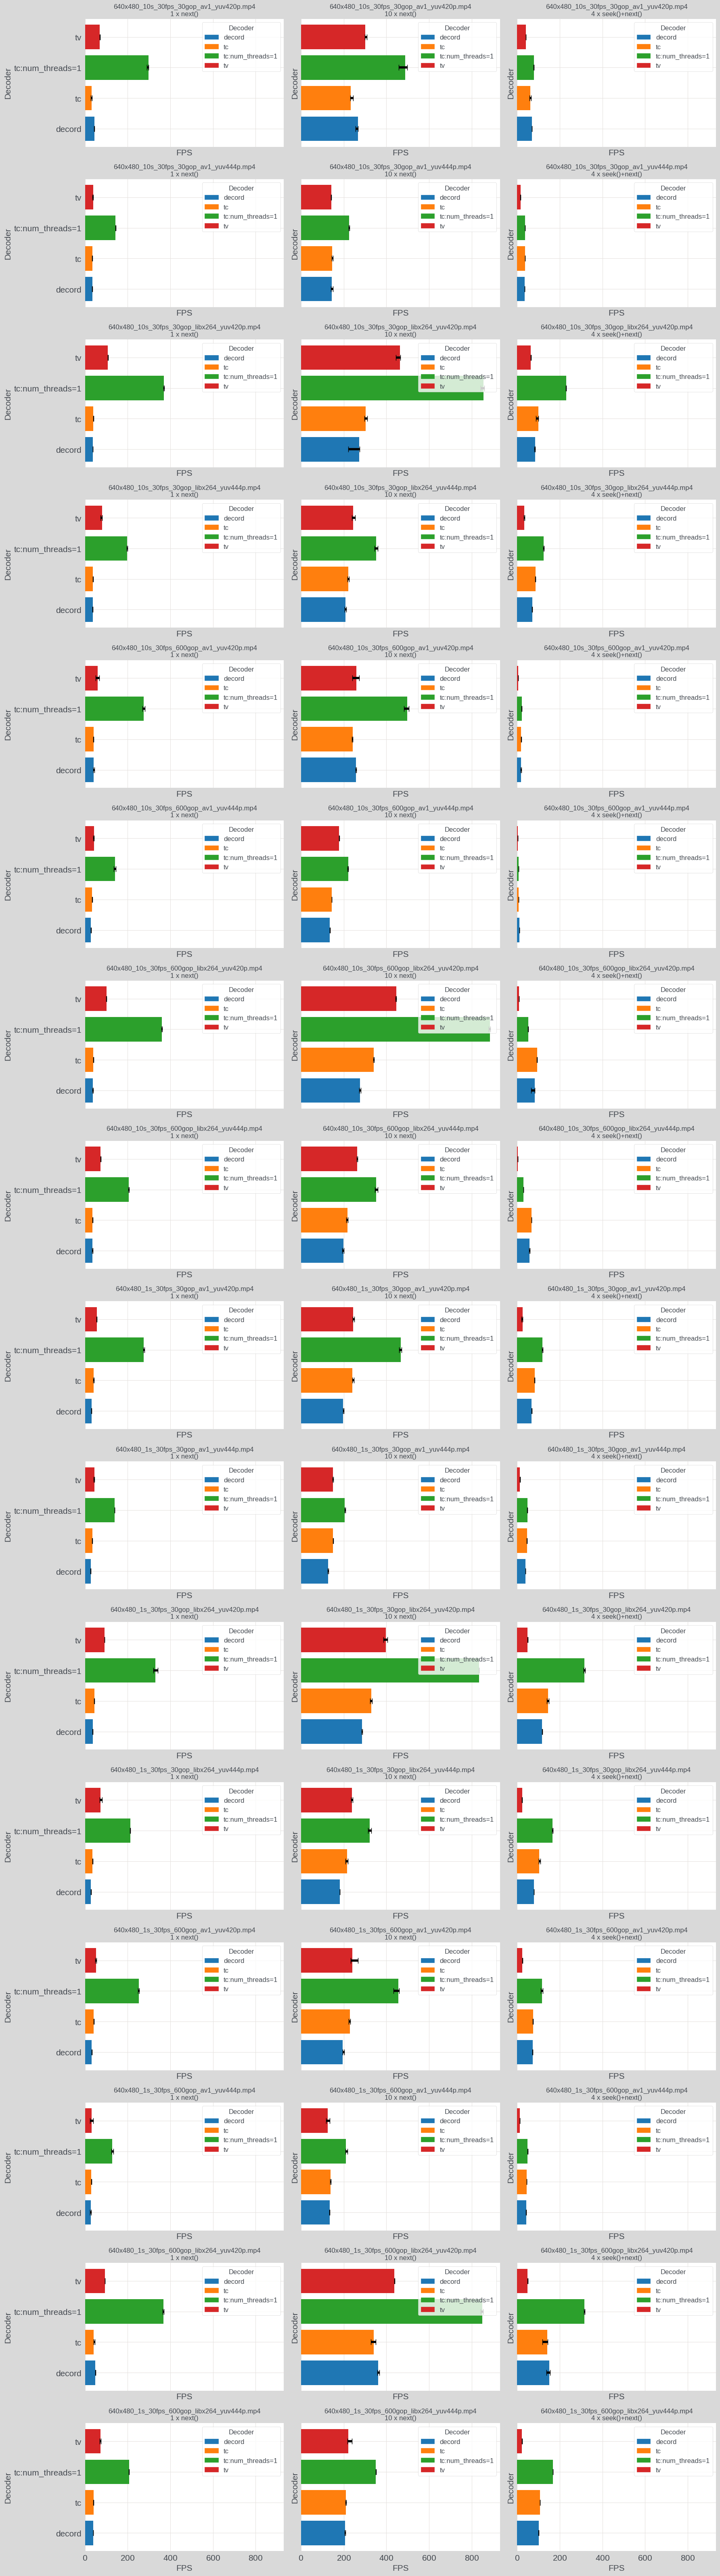

In [108]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Creating the DataFrame
df = pd.DataFrame(df_data)

# Sorting by video, type, and frame_count
df_sorted = df.sort_values(by=['video', 'type', 'frame_count'])

# Group by video first
grouped_by_video = df_sorted.groupby('video')

# Define colors (consistent across decoders)
colors = plt.get_cmap('tab10')

# Find the unique combinations of (type, frame_count) per video
video_type_combinations = {
    video: video_group.groupby(['type', 'frame_count']).ngroups
    for video, video_group in grouped_by_video
}

# Get the unique videos and the maximum number of (type, frame_count) combinations per video
unique_videos = list(video_type_combinations.keys())
max_combinations = max(video_type_combinations.values())

# Create subplots: each row is a video, and each column is for a unique (type, frame_count)
fig, axes = plt.subplots(nrows=len(unique_videos),
                         ncols=max_combinations,
                         figsize=(max_combinations*6, len(unique_videos)*4),
                         sharex=True, sharey=True)

# Handle cases where there's only one row or column
if len(unique_videos) == 1:
    axes = np.array([axes])  # Make sure axes is a list of lists
if max_combinations == 1:
    axes = np.expand_dims(axes, axis=1)  # Ensure a 2D array for axes

# Loop through each video and its sub-groups
for row, (video, video_group) in enumerate(grouped_by_video):
    sub_group = video_group.groupby(['type', 'frame_count'])

    # Loop through each (type, frame_count) group for this video
    for col, ((vtype, vcount), group) in enumerate(sub_group):
        ax = axes[row, col]  # Select the appropriate axis

        # Set the title for the subplot
        base_video = os.path.basename(video)
        ax.set_title(f'{base_video}\n{vcount} x {vtype}', fontsize=12)

        # Plot bars with error bars
        ax.barh(
            group['decoder'],
            group['fps'],
            xerr=[group['fps'] - group['fps_p75'], group['fps_p25'] - group['fps']],
            color=[colors(i) for i in range(len(group))],
            align='center',
            capsize=5,
        )

        # Set the labels
        ax.set_xlabel('FPS')
        ax.set_ylabel('Decoder')

        # Reverse the order of the handles and labels to match the order of the bars
        handles = [plt.Rectangle((0, 0), 1, 1, color=colors(i)) for i in range(len(group))]
        ax.legend(handles[::-1], group['decoder'][::-1], title='Decoder', loc='upper right')

# Remove any empty subplots for videos with fewer combinations
for row in range(len(unique_videos)):
    for col in range(video_type_combinations[unique_videos[row]], max_combinations):
        fig.delaxes(axes[row, col])

# Adjust layout to avoid overlap
plt.tight_layout()

# Show plot
plt.savefig("/home/ahmads/personal/torchcodec/benchmarks/decoders/benchmark_results.png")
